In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pymc3 as pm
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale
from theano import shared
import theano.tensor as T
from pymc3 import *
import warnings
warnings.filterwarnings('ignore')

In [15]:
#Importing dataset
df = pd.read_csv('breast-cancer-wisconsin.csv')
df.drop(['id'],1,inplace=True)

# Convert '?' to NaN
df[df == '?'] = np.nan
# Drop missing values and print shape of new DataFrame
df = df.dropna()

X = scale(np.array(df.drop(['class'],1)))
y = np.array(df['class'])/2-1

#Split Data
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2, random_state=42)

#Preprocess data for Modeling
ann_input = shared(X_tr)
ann_output = shared(y_tr)

n_hidden = 5

In [16]:
init_1 = np.random.randn(X.shape[1], n_hidden)
init_2 = np.random.randn(n_hidden, n_hidden)
init_out = np.random.randn(n_hidden)

with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1,
    shape=(X.shape[1], n_hidden),
    testval=init_1)

    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                        shape=(n_hidden, n_hidden),
                        testval=init_2)

    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                          shape=(n_hidden,),
                          testval=init_out)

    # Build neural-network
    act_1 = T.tanh(T.dot(ann_input, weights_in_1))
    act_2 = T.tanh(T.dot(act_1, weights_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, weights_2_out))

    out = pm.Bernoulli('data',
                   act_out,
                   observed=ann_output)

In [41]:
#infering parameters
with neural_network:
    advi=pm.ADVI()
    approx = advi.fit(n=5000,more_replacements={
        ann_input:pm.Minibatch(X_tr),
        ann_output:pm.Minibatch(y_tr)
    
     }
        )

Average Loss = 51.348: 100%|███████████████████████████████████████████████████████| 5000/5000 [07:39<00:00, 10.89it/s]
Finished [100%]: Average Loss = 51.262


In [18]:
#Replace shared variables with testing set
#(note that using this trick we could be streaming ADVI for big data)
ann_input.set_value(X_te)
ann_output.set_value(y_te)

In [19]:
#Creater posterior predictive samples
trace= approx.sample(draws=5000)
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)
pred = ppc['data'].mean(axis=0) > 0.5

print('Accuracy = {}%'.format((y_te == pred).mean() * 100))

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 548.23it/s]


Accuracy = 97.8102189781022%


(137, 9)
(137,)
(137,)


ValueError: cannot reshape array of size 137 into shape (11,11)

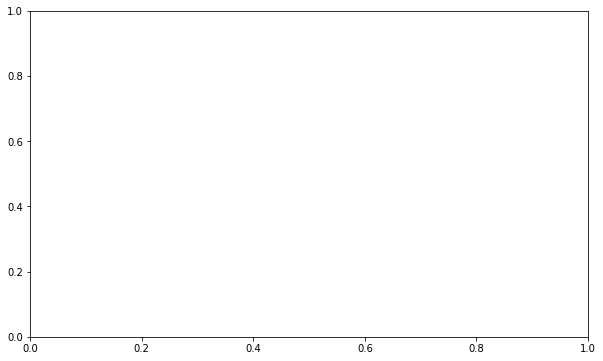

In [39]:
import seaborn as sns

grid = np.mgrid[-3:3:100j,-3:3:100j]

grid_2d = grid.reshape(2, -1).T

dummy_out = np.ones(grid.shape[1], dtype=np.int8)

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['data'].std(axis=0).reshape(11,11), cmap=cmap)
ax.scatter(X_te[pred==0, 0], X_te[pred==0, 1])
ax.scatter(X_te[pred==1, 0], X_te[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');